Submission files saved successfully.


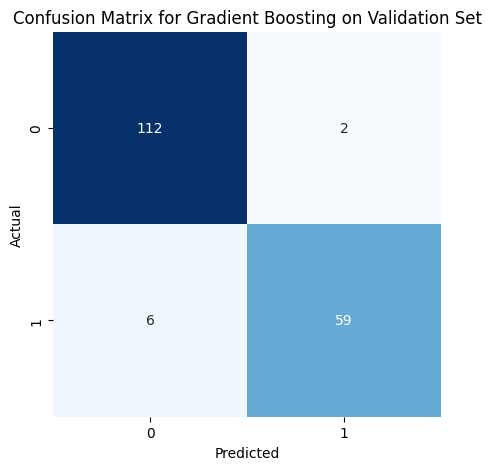

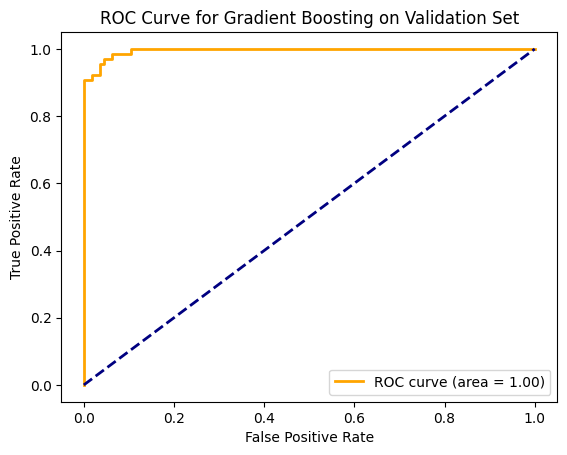

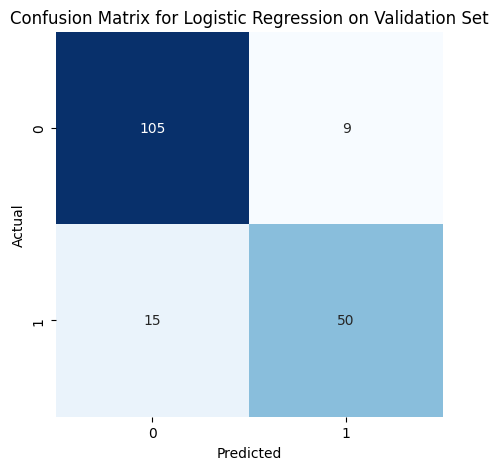

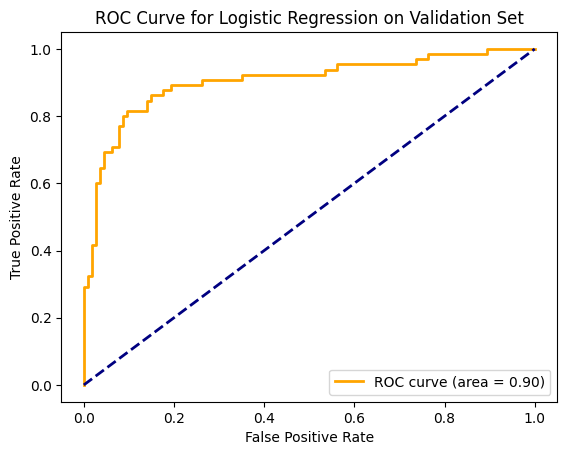

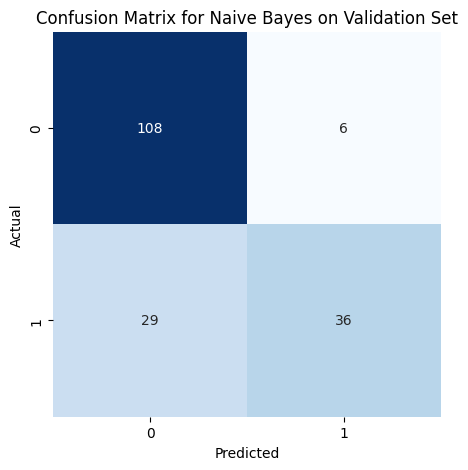

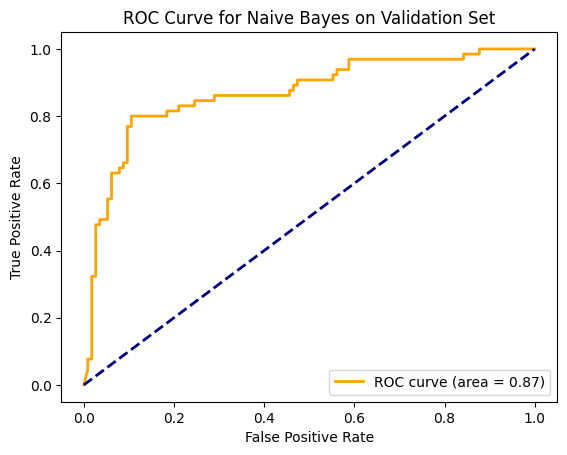


Performance Metrics for the Improved Gradient Boosting Model on Validation Set:
Accuracy: 0.9553
Precision: 0.9672
Recall: 0.9077
F1 Score: 0.9365
ROC AUC: 0.9954
Confusion Matrix:
[[112   2]
 [  6  59]]

Performance Metrics for the Logistic Regression Model on Validation Set:
Accuracy: 0.8659
Precision: 0.8475
Recall: 0.7692
F1 Score: 0.8065
ROC AUC: 0.9042
Confusion Matrix:
[[105   9]
 [ 15  50]]

Performance Metrics for the Naive Bayes Model on Validation Set:
Accuracy: 0.8045
Precision: 0.8571
Recall: 0.5538
F1 Score: 0.6729
ROC AUC: 0.8690
Confusion Matrix:
[[108   6]
 [ 29  36]]


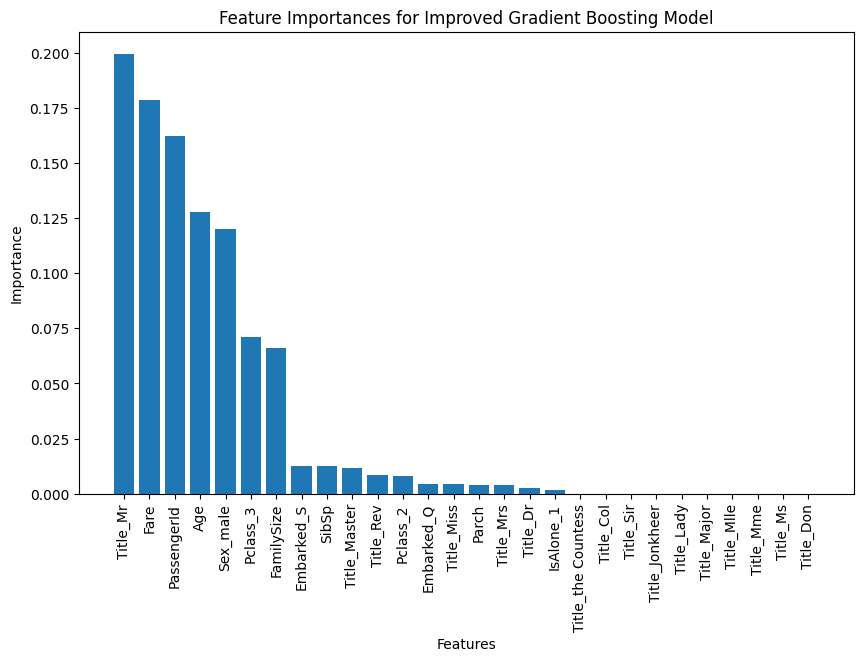

In [15]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

# Load the Titanic training data
train_data = pd.read_csv('/mnt/train(1).csv')

# Load the Titanic test data
test_data = pd.read_csv('/mnt/test(1).csv')

# Split Data into Features and Target
def split_input_output(data, target_col):
    """
    Splits the data into features (X) and target (y).
    """
    X = data.drop(columns=[target_col])
    y = data[target_col]
    return X, y

X, y = split_input_output(train_data, 'Survived')

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

# Define preprocessing functions
def fill_missing_values(data):
    """
    Fills missing values in the dataset.
    """
    data = deepcopy(data)
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    if 'Cabin' in data.columns:
        data.drop(columns=['Cabin'], inplace=True)
    return data

def create_new_features(data):
    """
    Creates new features in the dataset.
    """
    data = deepcopy(data)
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
    data['Title'] = data['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
    return data

def drop_unnecessary_columns(data):
    """
    Drops unnecessary columns from the dataset.
    """
    data = deepcopy(data)
    data.drop(columns=['Name', 'Ticket'], inplace=True)
    return data

def encode_categorical(data):
    """
    Encodes categorical variables using one-hot encoding.
    """
    data = deepcopy(data)
    categorical_cols = ['Pclass', 'Sex', 'Embarked', 'IsAlone', 'Title']
    data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
    return data

def standardize_numerical(data):
    """
    Standardizes numerical features in the dataset.
    """
    data = deepcopy(data)
    numerical_cols = ['Age', 'Fare', 'FamilySize']
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
    return data

# Preprocess training and validation sets
def preprocess_data(data):
    """
    Preprocesses the data by filling missing values, creating new features,
    dropping unnecessary columns, encoding categorical variables, and standardizing numerical features.
    """
    data = deepcopy(data)
    data = fill_missing_values(data)
    data = create_new_features(data)
    data = drop_unnecessary_columns(data)
    data = encode_categorical(data)
    data = standardize_numerical(data)
    return data

X_train_preprocessed = preprocess_data(X_train)
X_valid_preprocessed = preprocess_data(X_valid)

# Ensure consistent column order and alignment
X_train_preprocessed, X_valid_preprocessed = X_train_preprocessed.align(X_valid_preprocessed, join='outer', axis=1, fill_value=0)

# Combine training and validation sets
X_train_full = pd.concat([X_train_preprocessed, X_valid_preprocessed], ignore_index=True)
y_train_full = pd.concat([y_train, y_valid], ignore_index=True)

# Handle any remaining NaN values
X_train_full.fillna(0, inplace=True)
X_valid_preprocessed.fillna(0, inplace=True)

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': sp_randint(3, 10),
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 20),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=123)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(gb_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=123, n_jobs=-1)

# Fit RandomizedSearchCV
random_search.fit(X_train_full, y_train_full)

# Get the best Gradient Boosting model
best_gb_model = random_search.best_estimator_

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']
}

# Initialize the Logistic Regression model
lr_model = LogisticRegression(random_state=123)

# Initialize GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(lr_model, param_grid=param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search_lr.fit(X_train_full, y_train_full)

# Get the best Logistic Regression model
best_lr_model = grid_search_lr.best_estimator_

# Initialize and fit Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_full, y_train_full)

# Preprocess the test data
X_test_preprocessed = preprocess_data(test_data)
X_test_preprocessed = X_test_preprocessed.reindex(columns=X_train_preprocessed.columns, fill_value=0)

# Handle any remaining NaN values
X_test_preprocessed.fillna(0, inplace=True)

# Predictions on the test set for each model
y_test_pred_gb = best_gb_model.predict(X_test_preprocessed)
y_test_pred_lr = best_lr_model.predict(X_test_preprocessed)
y_test_pred_nb = nb_model.predict(X_test_preprocessed)

# Create submission DataFrames
submission_gb = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': y_test_pred_gb
})

submission_lr = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': y_test_pred_lr
})

submission_nb = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': y_test_pred_nb
})

# Save submissions to CSV
submission_gb.to_csv('/mnt/submission_gb_improved.csv', index=False)
submission_lr.to_csv('/mnt/submission_lr.csv', index=False)
submission_nb.to_csv('/mnt/submission_nb.csv', index=False)

print("Submission files saved successfully.")

# Evaluate the models on the validation set
y_valid_pred_gb = best_gb_model.predict(X_valid_preprocessed)
y_valid_pred_lr = best_lr_model.predict(X_valid_preprocessed)
y_valid_pred_nb = nb_model.predict(X_valid_preprocessed)

y_valid_proba_gb = best_gb_model.predict_proba(X_valid_preprocessed)[:, 1]
y_valid_proba_lr = best_lr_model.predict_proba(X_valid_preprocessed)[:, 1]
y_valid_proba_nb = nb_model.predict_proba(X_valid_preprocessed)[:, 1]

# Plotting functions
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """
    Plots the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_roc_curve(y_true, y_proba, title='ROC Curve'):
    """
    Plots the ROC curve.
    """
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix and ROC Curve for Gradient Boosting
plot_confusion_matrix(y_valid, y_valid_pred_gb, title='Confusion Matrix for Gradient Boosting on Validation Set')
plot_roc_curve(y_valid, y_valid_proba_gb, title='ROC Curve for Gradient Boosting on Validation Set')

# Confusion Matrix and ROC Curve for Logistic Regression
plot_confusion_matrix(y_valid, y_valid_pred_lr, title='Confusion Matrix for Logistic Regression on Validation Set')
plot_roc_curve(y_valid, y_valid_proba_lr, title='ROC Curve for Logistic Regression on Validation Set')

# Confusion Matrix and ROC Curve for Naive Bayes
plot_confusion_matrix(y_valid, y_valid_pred_nb, title='Confusion Matrix for Naive Bayes on Validation Set')
plot_roc_curve(y_valid, y_valid_proba_nb, title='ROC Curve for Naive Bayes on Validation Set')

# Evaluate performance on the validation set for each model
metrics_valid_gb = {
    'Accuracy': accuracy_score(y_valid, y_valid_pred_gb),
    'Precision': precision_score(y_valid, y_valid_pred_gb),
    'Recall': recall_score(y_valid, y_valid_pred_gb),
    'F1 Score': f1_score(y_valid, y_valid_pred_gb),
    'ROC AUC': roc_auc_score(y_valid, y_valid_proba_gb),
    'Confusion Matrix': confusion_matrix(y_valid, y_valid_pred_gb)
}

metrics_valid_lr = {
    'Accuracy': accuracy_score(y_valid, y_valid_pred_lr),
    'Precision': precision_score(y_valid, y_valid_pred_lr),
    'Recall': recall_score(y_valid, y_valid_pred_lr),
    'F1 Score': f1_score(y_valid, y_valid_pred_lr),
    'ROC AUC': roc_auc_score(y_valid, y_valid_proba_lr),
    'Confusion Matrix': confusion_matrix(y_valid, y_valid_pred_lr)
}

metrics_valid_nb = {
    'Accuracy': accuracy_score(y_valid, y_valid_pred_nb),
    'Precision': precision_score(y_valid, y_valid_pred_nb),
    'Recall': recall_score(y_valid, y_valid_pred_nb),
    'F1 Score': f1_score(y_valid, y_valid_pred_nb),
    'ROC AUC': roc_auc_score(y_valid, y_valid_proba_nb),
    'Confusion Matrix': confusion_matrix(y_valid, y_valid_pred_nb)
}

print("\nPerformance Metrics for the Improved Gradient Boosting Model on Validation Set:")
for metric, value in metrics_valid_gb.items():
    if metric == 'Confusion Matrix':
        print(f'{metric}:\n{value}')
    else:
        print(f'{metric}: {value:.4f}')

print("\nPerformance Metrics for the Logistic Regression Model on Validation Set:")
for metric, value in metrics_valid_lr.items():
    if metric == 'Confusion Matrix':
        print(f'{metric}:\n{value}')
    else:
        print(f'{metric}: {value:.4f}')

print("\nPerformance Metrics for the Naive Bayes Model on Validation Set:")
for metric, value in metrics_valid_nb.items():
    if metric == 'Confusion Matrix':
        print(f'{metric}:\n{value}')
    else:
        print(f'{metric}: {value:.4f}')

# Plot feature importances for Gradient Boosting model
importances = best_gb_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train_full.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances for Improved Gradient Boosting Model")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()